In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from simulate import SimulationDataset  
import jax
from jax import jit, vmap, grad, random, value_and_grad
import jax.numpy as jnp


### Set device

In [3]:
seed = 0
# random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device("cpu")
    print("Using CPU")



Using MPS (Apple Silicon)


### Define the parameters for the simulation

In [4]:
ns = 10000
sim = 'spring'
n = 4
dim = 2
nt = 1000
dt = 1e-2

### Generate the dataset and see the shape

In [5]:
import simulate
from simulate import SimulationDataset
simulation = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
simulation.simulate(ns)

In [6]:
simulation.data.shape

(10000, 500, 4, 6)

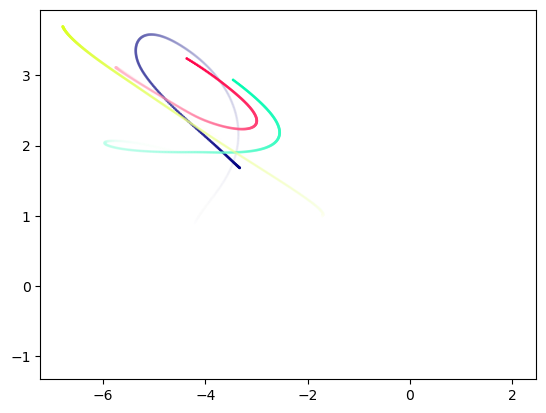

In [7]:
simulation.plot(0, animate=True, plot_size=False)

### Split the data and put into dataloader

In [8]:
accel_data = simulation.get_acceleration()

# Convert simulation and acceleration data directly to tensors
X = torch.tensor(np.array(simulation.data), dtype=torch.float32)  # Shape: (num_samples, num_time_steps, num_particles, num_features)
Y = torch.tensor(np.array(accel_data), dtype=torch.float32)       # Shape: (num_samples, num_time_steps, num_particles, output_dim)

# Select every 5th timestep along time dimension
X = X[:, ::5].reshape(-1, X.shape[2], X.shape[3])  # Flatten sample & time dims
Y = Y[:, ::5].reshape(-1, Y.shape[2], Y.shape[3])  # Flatten sample & time dims

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False)

In [9]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

torch.Size([750000, 4, 6]) torch.Size([250000, 4, 6]) torch.Size([750000, 4, 2]) torch.Size([250000, 4, 2])


In [10]:
from models import NbodyGNN,get_edge_index

edge_index = get_edge_index(n, sim)


from torch_geometric.data import Data, DataLoader

train_data_list = [
    Data(
        x=X_train[i],  
        edge_index=edge_index,  
        y=Y_train[i]
    ) for i in range(len(Y_train))
]


test_indices = np.random.choice(len(X_test), size=1024, replace=False)  # Randomly select 1024 indices from the test set
test_data_list = [
    Data(
        x=X_test[i],  
        edge_index=edge_index,  
        y=Y_test[i]
    ) for i in test_indices
]


batch = 64

trainloader = DataLoader(train_data_list, batch_size=batch, shuffle=True)
testloader = DataLoader(test_data_list, batch_size=1024, shuffle=False)


/Users/liuyihao/Desktop/yl2063/src/models.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e3pikzc5fh/croot/libtorch_1738337599132/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Standard model

In [11]:
aggr = 'add'
hidden = 300
msg_dim = 100
n_f = simulation.data.shape[3]

In [12]:
from torch.optim.lr_scheduler import OneCycleLR
initial_learing_rate = 1e-3


total_epochs = 30


batch_per_epoch = len(trainloader)


batch_per_epoch

11719

In [13]:

model_standard = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_standard = torch.optim.Adam(model_standard.parameters(), lr=initial_learing_rate, weight_decay=1e-8)


sched_standard = OneCycleLR(opt_standard, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [14]:
import wandb
wandb.init(project="DIS-final-pro", name="Train-spring-standard", reinit=True)

for epoch in range(total_epochs):
    model_standard.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_standard.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_standard.loss(batch)
        loss.backward()
        opt_standard.step()
        sched_standard.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: liuyihao649 (liuyihao649-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30, Loss: 8.274901
Epoch 2/30, Loss: 3.736582
Epoch 3/30, Loss: 2.941197
Epoch 4/30, Loss: 2.322236
Epoch 5/30, Loss: 1.793950
Epoch 6/30, Loss: 1.493980
Epoch 7/30, Loss: 1.326481
Epoch 8/30, Loss: 1.219893
Epoch 9/30, Loss: 1.120596
Epoch 10/30, Loss: 1.007530
Epoch 11/30, Loss: 0.925894
Epoch 12/30, Loss: 0.843337
Epoch 13/30, Loss: 0.776257
Epoch 14/30, Loss: 0.708521
Epoch 15/30, Loss: 0.654954
Epoch 16/30, Loss: 0.598819
Epoch 17/30, Loss: 0.552727
Epoch 18/30, Loss: 0.504260
Epoch 19/30, Loss: 0.463218
Epoch 20/30, Loss: 0.419281
Epoch 21/30, Loss: 0.377890
Epoch 22/30, Loss: 0.342938
Epoch 23/30, Loss: 0.310362
Epoch 24/30, Loss: 0.280854
Epoch 25/30, Loss: 0.253826
Epoch 26/30, Loss: 0.232380
Epoch 27/30, Loss: 0.214877
Epoch 28/30, Loss: 0.201825
Epoch 29/30, Loss: 0.193150
Epoch 30/30, Loss: 0.188897


In [15]:
# Save the model state
import os

root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "spring_standard.pth")

torch.save(model_standard.state_dict(), save_path)

In [26]:
import os
model_standard = NbodyGNN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "spring_standard.pth")
state_dict = torch.load(save_path, map_location=device)
model_standard.load_state_dict(state_dict)


model_standard.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_56041/3330496697.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locati

NbodyGNN()

In [16]:
model_standard.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_standard(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.023932


Selected channels: ['msg52', 'msg40']


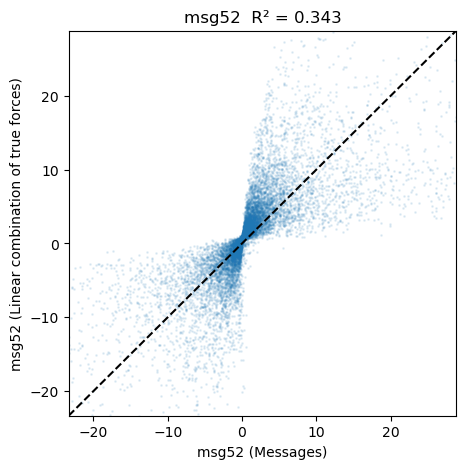

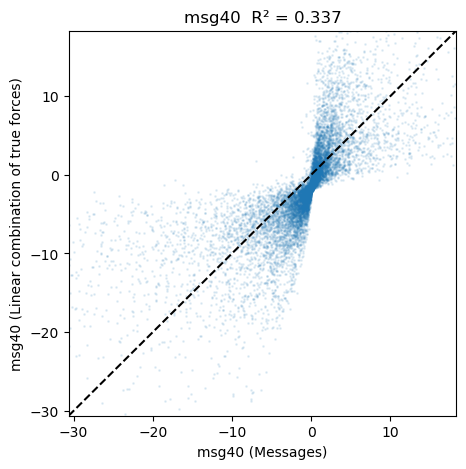

In [17]:

from message_processing import measure_latent, fit_multioutput_force
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Measure latent variables
latent_df_standard = measure_latent(model_standard, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_standard['fx_true'] = -(latent_df_standard['r'] - 1) * (latent_df_standard['dx'] / latent_df_standard['r'])
latent_df_standard['fy_true'] = -(latent_df_standard['r'] - 1) * (latent_df_standard['dy'] / latent_df_standard['r'])

# Fit multi-output linear regression to find top channels
lr, top_channels= fit_multioutput_force(latent_df_standard, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_standard[['fx_true','fy_true']].values

# True messages
Messages = latent_df_standard[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

# 
for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]          
    y_pred_ch = Predicted_messages[:, idx] 

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_ch, y_pred_ch, s=1, alpha=0.1)
    plt.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    plt.xlim(p_lower, p_upper)
    plt.ylim(p_lower, p_upper)
    plt.xlabel(f"{ch} (Messages)")
    plt.ylabel(f"{ch} (Linear combination of true forces)")

    single_r2 = r2_score(y_true_ch, y_pred_ch)
    plt.title(f"{ch}  R² = {single_r2:.3f}")
    plt.show()


In [18]:
import pysr
sr_standard= pysr.PySRRegressor(
  niterations=70,
  binary_operators=["+", "-", "*", "/"]
)
df_sub_standard = latent_df_standard[['dx','dy','r', top_channels[0]]].sample(5000)
X = df_sub_standard[['dx','dy','r']].values
Y = df_sub_standard[top_channels[0]].values
sr_standard.fit(X, Y)
print(sr_standard)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 1.930e+05
Progress: 1100 / 2170 total iterations (50.691%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.830e+02  1.594e+01  y = x₂
3           1.430e+02  1.234e-01  y = x₀ / -0.18329
5           1.350e+02  2.885e-02  y = (x₂ * x₀) / -0.40485
7           1.306e+02  1.631e-02  y = x₀ * ((10.926 / x₂) - 11.241)
9           1.290e+02  6.348e-03  y = x₀ * (((x₀ + 10.909) / x₂) - 11.224)
11          1.279e+02  4.153e-03  y = ((((x₀ + 10.891) / x₂) - 11.194) * x₀) - x₁
13          1.274e+02  2.154e-03  y = (x₀ * ((x₀ * 0.48314) + ((10.926 / x₂) - 11.241))) - x...
                                      ₁
15          1.272e+02  6.749e-04  y = ((x₀ * -0.98066) * ((((x₀ + -11.042) / x₂) + 11.367) -...
                                       x₀)) - x₁
17  

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.830e+02  1.594e+01  y = x₂
3           1.430e+02  1.234e-01  y = x₀ / -0.18329
5           1.350e+02  2.885e-02  y = (x₂ * x₀) / -0.40485
7           1.306e+02  1.631e-02  y = ((10.92 / x₂) - 11.239) * x₀
9           1.290e+02  6.348e-03  y = x₀ * (((x₀ + 10.909) / x₂) - 11.224)
11          1.279e+02  4.153e-03  y = ((((x₀ + 10.891) / x₂) - 11.194) * x₀) - x₁
13          1.273e+02  2.561e-03  y = ((((x₀ * 0.61188) + (10.847 / x₂)) - 11.16) * x₀) - x₁
15          1.272e+02  2.678e-04  y = ((x₀ * -0.98066) * ((((x₀ + -11.042) / x₂) + 11.367) -...
                                       x₀)) - x₁
17          1.271e+02  4.610e-04  y = ((x₀ * (((12.648 - x₀) + ((x₀ + -12.29) / x₂)) / -1.13...
                                      4)) - x₁) + 0.37699
19          1.162e+02  4.474e-02  y = (x₀ * ((10.926 / x₂) - 11.241)) - (x₁ - (x₀ / ((x₀ 

### Bottleneck model

In [ ]:

msg_dim_bottleneck=2

model_bottleneck = NbodyGNN(n_f, msg_dim_bottleneck, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_bottleneck = torch.optim.Adam(model_bottleneck.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_bottleneck = OneCycleLR(opt_bottleneck, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)


In [ ]:
import wandb
wandb.init(project="DIS-final-pro", name="Train-spring-bottleneck", reinit=True)
for epoch in range(total_epochs):
    model_bottleneck.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_bottleneck.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_bottleneck.loss(batch)
        loss.backward()
        opt_bottleneck.step()
        sched_bottleneck.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: liuyihao649 (liuyihao649-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30, Loss: 10.854698
Epoch 2/30, Loss: 6.004095
Epoch 3/30, Loss: 3.923622
Epoch 4/30, Loss: 2.869835
Epoch 5/30, Loss: 1.996087
Epoch 6/30, Loss: 1.529164
Epoch 7/30, Loss: 1.226941
Epoch 8/30, Loss: 1.045741
Epoch 9/30, Loss: 0.923404
Epoch 10/30, Loss: 0.828323
Epoch 11/30, Loss: 0.771025
Epoch 12/30, Loss: 0.714397
Epoch 13/30, Loss: 0.663543
Epoch 14/30, Loss: 0.618198
Epoch 15/30, Loss: 0.581272
Epoch 16/30, Loss: 0.534236
Epoch 17/30, Loss: 0.493610
Epoch 18/30, Loss: 0.454085
Epoch 19/30, Loss: 0.412250
Epoch 20/30, Loss: 0.370441
Epoch 21/30, Loss: 0.334811
Epoch 22/30, Loss: 0.299395
Epoch 23/30, Loss: 0.268414
Epoch 24/30, Loss: 0.236257
Epoch 25/30, Loss: 0.213232
Epoch 26/30, Loss: 0.191043
Epoch 27/30, Loss: 0.175094
Epoch 28/30, Loss: 0.162359
Epoch 29/30, Loss: 0.154223
Epoch 30/30, Loss: 0.150131


In [20]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "spring_bottleneck.pth")

torch.save(model_bottleneck.state_dict(), save_path)

In [21]:
model_bottleneck.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_bottleneck(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.019942


Selected channels: ['msg1', 'msg0']


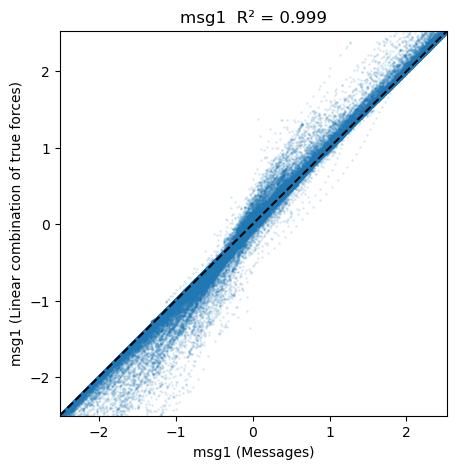

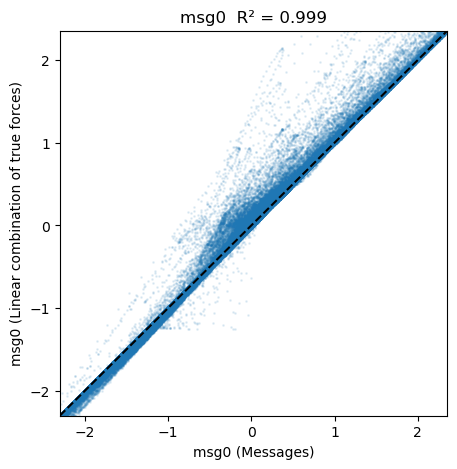

In [ ]:
from message_processing import measure_latent, fit_multioutput_force
from sklearn.metrics import r2_score

# Measure latent variables
latent_df_bottleneck = measure_latent(model_bottleneck, testloader, device=device, dim=dim, n_f=n_f, msg_dim=msg_dim_bottleneck)

# compute true force components and add them to latent_df
latent_df_bottleneck['fx_true'] = -(latent_df_bottleneck['r'] - 1) * (latent_df_bottleneck['dx'] / latent_df_bottleneck['r'])
latent_df_bottleneck['fy_true'] = -(latent_df_bottleneck['r'] - 1) * (latent_df_bottleneck['dy'] / latent_df_bottleneck['r'])

# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_bottleneck, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_bottleneck[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_bottleneck[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_ch, y_pred_ch, s=1, alpha=0.1)
    plt.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    plt.xlim(p_lower, p_upper)
    plt.ylim(p_lower, p_upper)
    plt.xlabel(f"{ch} (Messages)")
    plt.ylabel(f"{ch} (Linear combination of true forces)")

    single_r2 = r2_score(y_true_ch, y_pred_ch)
    plt.title(f"{ch}  R² = {single_r2:.3f}")
    plt.show()

In [25]:
import pysr
sr_bottleneck = pysr.PySRRegressor(
    niterations=70,
    binary_operators=["+", "-", "*", "/"]
)
df_sub_bottleneck = latent_df_bottleneck[['dx', 'dy', 'r', top_channels[0]]].sample(5000)
X = df_sub_bottleneck[['dx', 'dy', 'r']].values
Y = df_sub_bottleneck[top_channels[0]].values
sr_bottleneck.fit(X, Y)
print(sr_bottleneck)



/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 1.900e+05
Progress: 1071 / 2170 total iterations (49.355%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.529e-01  1.594e+01  y = x₁
3           4.130e-01  3.002e-01  y = x₁ * 0.50257
5           1.925e-01  3.816e-01  y = (x₀ + x₁) * 0.44933
7           7.623e-02  4.632e-01  y = (x₂ * (x₀ + x₁)) * 0.20511
9           8.817e-03  1.079e+00  y = ((-0.94308 / x₂) + 0.95258) * (x₀ + x₁)
11          7.231e-04  1.250e+00  y = ((-1.0426 / x₂) + 1.0534) * (x₁ - (x₀ * -0.80955))
13          5.787e-04  1.114e-01  y = (((-1.0424 / x₂) + 1.0532) * (x₁ - (x₀ * -0.80934))) +...
                                       0.012019
15          5.530e-04  2.279e-02  y = (((x₁ - (x₀ * -0.80942)) + -0.0029819) * ((-1.043 / x₂...
                                      ) 

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.529e-01  1.594e+01  y = x₁
3           4.130e-01  3.002e-01  y = x₁ * 0.50257
5           1.925e-01  3.816e-01  y = (x₀ + x₁) * 0.44933
7           7.623e-02  4.632e-01  y = (x₂ * (x₀ + x₁)) * 0.20511
9           8.817e-03  1.079e+00  y = ((-0.94308 / x₂) + 0.95258) * (x₀ + x₁)
11          7.231e-04  1.250e+00  y = ((-1.0426 / x₂) + 1.0534) * (x₁ - (x₀ * -0.80955))
13          5.787e-04  1.114e-01  y = ((x₁ - (x₀ * -0.80934)) * ((-1.0424 / x₂) + 1.0532)) +...
                                       0.012019
15          5.530e-04  2.279e-02  y = (((x₁ - (x₀ * -0.80942)) + -0.0029819) * ((-1.043 / x₂...
                                      ) + 1.0535)) + 0.01208
21          5.476e-04  1.617e-03  y = (((-0.84412 / x₂) + 0.85264) * ((x₂ + ((x₀ - (x₁ * -1....
                                      2356)) - 0.0043734)) + (x₂ * -0.99611)))

### L1 regularization model

In [ ]:
model_l1 = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0.02).to(device)

opt_l1 = torch.optim.Adam(model_l1.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_l1 = OneCycleLR(opt_l1, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [ ]:
wandb.init(project="DIS-final-pro", name="Train-spring-l1", reinit=True)
for epoch in range(total_epochs):
    model_l1.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_l1.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_l1.loss(batch)
        loss.backward()
        opt_l1.step()
        sched_l1.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.15013


Epoch 1/30, Loss: 15.725182
Epoch 2/30, Loss: 7.885245
Epoch 3/30, Loss: 4.769482
Epoch 4/30, Loss: 3.706812
Epoch 5/30, Loss: 2.968559
Epoch 6/30, Loss: 2.436464
Epoch 7/30, Loss: 2.196666
Epoch 8/30, Loss: 2.082072
Epoch 9/30, Loss: 1.980399
Epoch 10/30, Loss: 1.851122
Epoch 11/30, Loss: 1.736118
Epoch 12/30, Loss: 1.626139
Epoch 13/30, Loss: 1.519717
Epoch 14/30, Loss: 1.429508
Epoch 15/30, Loss: 1.350163
Epoch 16/30, Loss: 1.243634
Epoch 17/30, Loss: 1.160351
Epoch 18/30, Loss: 1.082105
Epoch 19/30, Loss: 0.999358
Epoch 20/30, Loss: 0.920323
Epoch 21/30, Loss: 0.848642
Epoch 22/30, Loss: 0.776270
Epoch 23/30, Loss: 0.708890
Epoch 24/30, Loss: 0.647552
Epoch 25/30, Loss: 0.591639
Epoch 26/30, Loss: 0.545817
Epoch 27/30, Loss: 0.507931
Epoch 28/30, Loss: 0.479054
Epoch 29/30, Loss: 0.459953
Epoch 30/30, Loss: 0.449814


In [28]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "spring_l1.pth")

torch.save(model_l1.state_dict(), save_path)

In [29]:
model_l1.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_l1(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 0.045175


Selected channels: ['msg49', 'msg97']


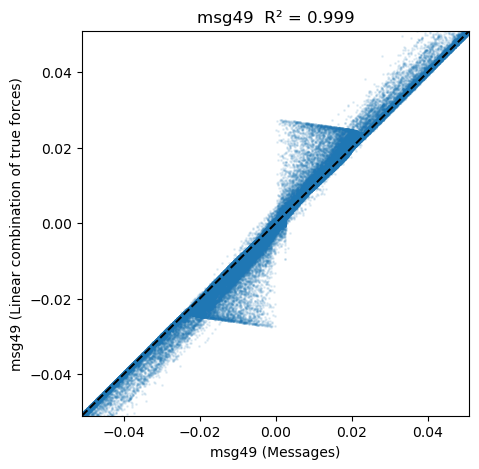

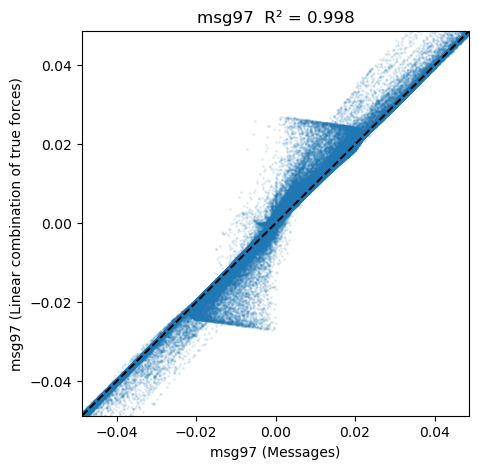

In [30]:
# Measure latent variables
latent_df_l1 = measure_latent(model_l1, testloader, device=device, dim=dim, n_f=n_f, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_l1['fx_true'] = -(latent_df_l1['r'] - 1) * (latent_df_l1['dx'] / latent_df_l1['r'])
latent_df_l1['fy_true'] = -(latent_df_l1['r'] - 1) * (latent_df_l1['dy'] / latent_df_l1['r'])

# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_l1, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_l1[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_l1[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_ch, y_pred_ch, s=1, alpha=0.1)
    plt.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    plt.xlim(p_lower, p_upper)
    plt.ylim(p_lower, p_upper)
    plt.xlabel(f"{ch} (Messages)")
    plt.ylabel(f"{ch} (Linear combination of true forces)")

    single_r2 = r2_score(y_true_ch, y_pred_ch)
    plt.title(f"{ch}  R² = {single_r2:.3f}")
    plt.show()


In [31]:
import pysr
sr_l1 = pysr.PySRRegressor(
    niterations=70,
    binary_operators=["+", "-", "*", "/"]
)
df_sub_l1 = latent_df_l1[['dx', 'dy', 'r', top_channels[0]]].sample(5000)
X = df_sub_l1[['dx', 'dy', 'r']].values
Y = df_sub_l1[top_channels[0]].values
sr_l1.fit(X, Y)
print(sr_l1)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 1.960e+05
Progress: 1132 / 2170 total iterations (52.166%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.035e-04  1.594e+01  y = 0
3           1.269e-04  4.360e-01  y = x₀ * 0.011393
5           8.395e-05  2.066e-01  y = (x₂ * 0.005452) * x₀
7           3.783e-05  3.986e-01  y = (x₁ + (x₀ * x₂)) * 0.0054391
9           2.778e-05  1.544e-01  y = (((x₀ * 1.8906) + x₁) * x₂) * 0.0027839
11          2.358e-05  8.187e-02  y = (x₀ + x₁) * (((x₂ + -0.98905) * 0.018562) / x₂)
13          4.822e-07  1.945e+00  y = ((x₂ + -0.98641) / (x₂ * 82.033)) * (x₀ + (x₁ + x₀))
15          3.824e-07  1.159e-01  y = (((x₁ * 1.0195) + x₀) + x₀) * ((x₂ + -0.98641) / (x₂ *...
                                       82.033))
17          3.205e-07  8.830e-02  y = ((x₂ + 

### KL divergence model

In [9]:
from models import VariationNbody

In [ ]:
model_kl = VariationNbody(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), beta=1.0).to(device)

opt_kl = torch.optim.Adam(model_kl.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_kl = OneCycleLR(opt_kl, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [ ]:
import wandb
wandb.init(project="DIS-final-pro-kl", name="Train-spring", reinit=True)
for epoch in range(total_epochs):
    model_kl.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_kl.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_kl.loss(batch)
        loss.backward()
        opt_kl.step()
        sched_kl.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: liuyihao649 (liuyihao649-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30, Loss: 3.065439
Epoch 2/30, Loss: 2.730487
Epoch 3/30, Loss: 2.646423
Epoch 4/30, Loss: 2.561632
Epoch 5/30, Loss: 2.373220
Epoch 6/30, Loss: 2.295418
Epoch 7/30, Loss: 2.255186
Epoch 8/30, Loss: 2.237872
Epoch 9/30, Loss: 2.223682
Epoch 10/30, Loss: 2.211939
Epoch 11/30, Loss: 2.202670
Epoch 12/30, Loss: 2.195272
Epoch 13/30, Loss: 2.186671
Epoch 14/30, Loss: 2.181136
Epoch 15/30, Loss: 2.173671
Epoch 16/30, Loss: 2.166157
Epoch 17/30, Loss: 2.160559
Epoch 18/30, Loss: 2.153943
Epoch 19/30, Loss: 2.147247
Epoch 20/30, Loss: 2.141023
Epoch 21/30, Loss: 2.134420
Epoch 22/30, Loss: 2.128903
Epoch 23/30, Loss: 2.122889
Epoch 24/30, Loss: 2.118001
Epoch 25/30, Loss: 2.114012
Epoch 26/30, Loss: 2.110244
Epoch 27/30, Loss: 2.106594
Epoch 28/30, Loss: 2.104177
Epoch 29/30, Loss: 2.102865
Epoch 30/30, Loss: 2.103036


In [18]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "spring_kl.pth")

torch.save(model_kl.state_dict(), save_path)

In [13]:
model_kl.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_kl(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 1.452993


Top μ channels: ['mu41', 'mu73']
Multi-output μ‐linear fit R² = 0.4920


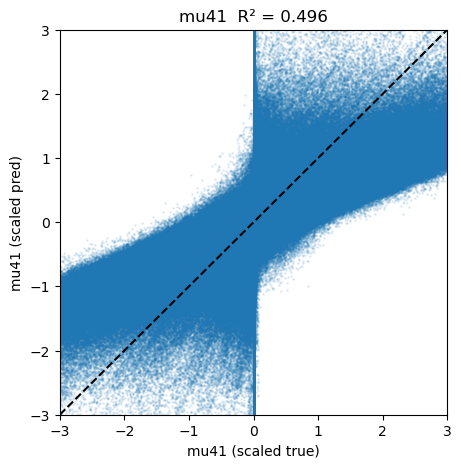

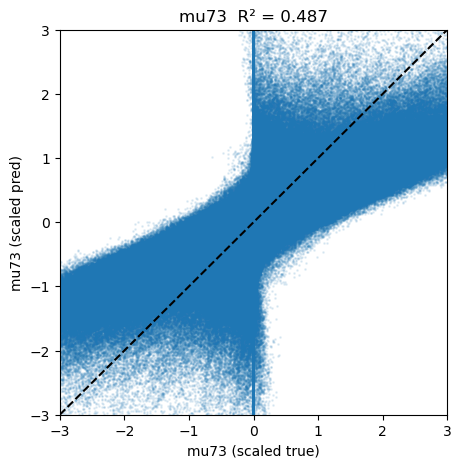

In [19]:
from message_processing import measure_variational_latent
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score   

df = measure_variational_latent(
    model_kl, testloader, device=device,
    dim=dim, msg_dim=msg_dim
)

# 1) 选出方差最大的 dim 个 mu 通道
mu_cols = [c for c in df.columns if c.startswith("mu")]
top_mu  = df[mu_cols].std().nlargest(dim).index.tolist()
print("Top μ channels:", top_mu)

# 2) 计算真实力，并拼成 X
df['fx_true'] = -(df['r'] - 1) * (df['dx'] / df['r'])
df['fy_true'] = -(df['r'] - 1) * (df['dy'] / df['r'])
X_raw = df[['fx_true','fy_true']].values       # (N,2)
Y_mu   = df[top_mu].values                     # (N,dim)

# 3) 标准化
scaler_X  = StandardScaler().fit(X_raw)
scaler_Ymu = StandardScaler().fit(Y_mu)
Xs  = scaler_X.transform(X_raw)
Ysm = scaler_Ymu.transform(Y_mu)

# 4) 拟合 & 得到整体 R²
lr_mu = LinearRegression().fit(Xs, Ysm)
r2_mu = lr_mu.score(Xs, Ysm)
print(f"Multi-output μ‐linear fit R² = {r2_mu:.4f}")

# 5) 可视化：每个 μ 通道的真值 vs 预测
for i, ch in enumerate(top_mu):
    Y_true = Ysm[:, i]
    Y_pred = lr_mu.predict(Xs)[:, i]

    plt.figure(figsize=(5,5))
    plt.scatter(Y_true, Y_pred, s=1, alpha=0.1)
    plt.plot([-3,3],[-3,3],'k--')
    plt.xlim(-3,3); plt.ylim(-3,3)
    plt.xlabel(f"{ch} (scaled true)")
    plt.ylabel(f"{ch} (scaled pred)")
    r2_chan = r2_score(Y_true, Y_pred)
    plt.title(f"{ch}  R² = {r2_chan:.3f}")
    plt.show()

In [22]:

import pysr
sr_kl = pysr.PySRRegressor(
    niterations=70,
    binary_operators=["+", "-", "*", "/"]
)
df_sub_kl = df[['dx', 'dy', 'r', top_mu[0]]].sample(5000)
X = df_sub_kl[['dx', 'dy', 'r']].values
Y = df_sub_kl[top_mu[0]].values
sr_kl.fit(X, Y)
print(sr_kl)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 2.070e+05
Progress: 1153 / 2170 total iterations (53.134%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.436e-01  1.594e+01  y = 0.0031465
3           2.429e-01  1.734e-01  y = x₀ * 0.26836
5           2.214e-01  4.634e-02  y = (x₁ + x₀) * 0.20792
7           2.025e-01  4.451e-02  y = ((x₂ * x₀) + x₁) * 0.12208
9           1.986e-01  9.826e-03  y = (x₂ * ((x₁ * 0.5595) + x₀)) * 0.11742
11          1.918e-01  1.732e-02  y = ((x₂ + -0.9262) * (0.41094 / x₂)) * (x₀ + x₁)
13          1.786e-01  3.565e-02  y = (((x₂ + -0.93149) * (x₀ + (x₁ * 0.54348))) * 0.5349) /...
                                       x₂
15          1.766e-01  5.757e-03  y = ((x₁ + x₀) + x₀) * (((0.36238 / x₂) - 0.034037) * (x₂ ...
                                      + -0.940